First, let's install some libraries that we will need

In [5]:
!pip install imageio matplotlib numpy pillow scipy tqdm opencv-python-headless ipywidgets jupyterlab_widgets

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple


In [6]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from utils import draw_matches, draw_matches_rtol, load_bear, load_chessboard, load_fox, show_fig_switcher

# Feature matching and filtration

In this practical session we will get familiar with feature matching.
We will start with a straightforward matching method and will iteratively make it more sophisticated to eliminate false matches.

**You have two tasks:**
- Implement parts of the filtration pipeline. Look fo the code blocks labeled with 'Your code', both in the program code and the docstrings.
- Answer the questions in bold text. Write the answer just below the question in the same Markdown cell.

First, let's load a pair of images captured from different viewpoints and prepare them for feature extraction.

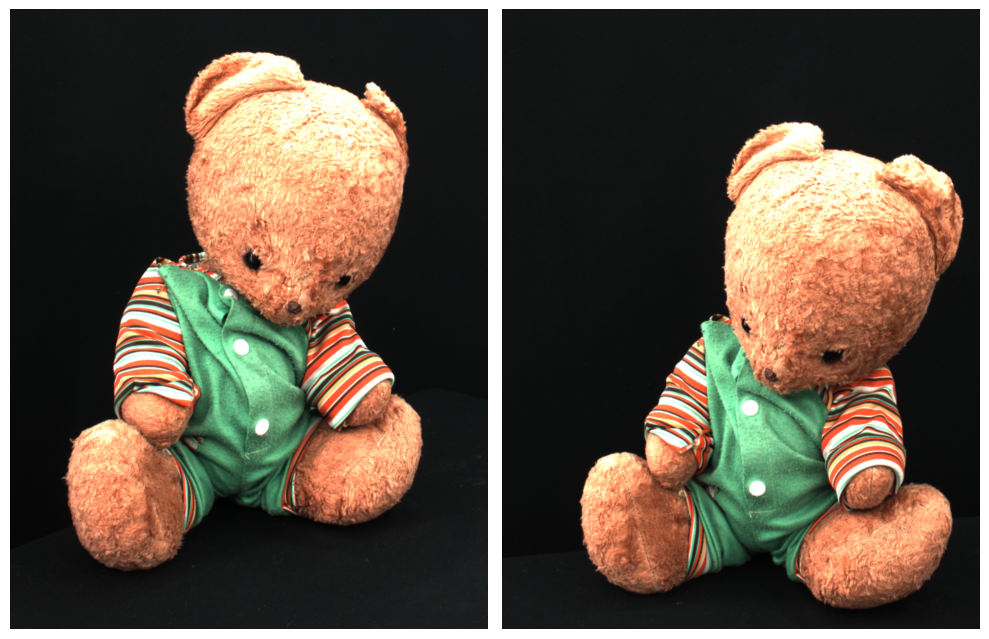

In [7]:
# We will keep the data that we will use repeatedly in this `data` dictionary
data = dict()

# Put here the path to the folder containing the folder plush_bear
# e.g data_dir = '/data' if the photos of the bear are in '/data/plush_bear'
data_dir = '/home/malus/Computer Vision Learning/proj/07-08.data/07-08.data'

# Load the color images
data['img'] = load_bear(data_dir)
# data['img'] = load_fox(data_dir)  # You can use the fox instead for debugging. In this pair, the second image is a rotated and scaled version of the first one.

# Convert to grayscale for feature extraction
data['gray'] = [np.clip(img.mean(-1).round(), 0, 255).astype(np.uint8) for img in data['img']]

# Visualize the color images
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
for img, ax in zip(data['img'], axes):
    ax.imshow(img)
    ax.set_axis_off()
plt.tight_layout()

We will experiment with the SIFT features.
Let's extract them for this pair of images.

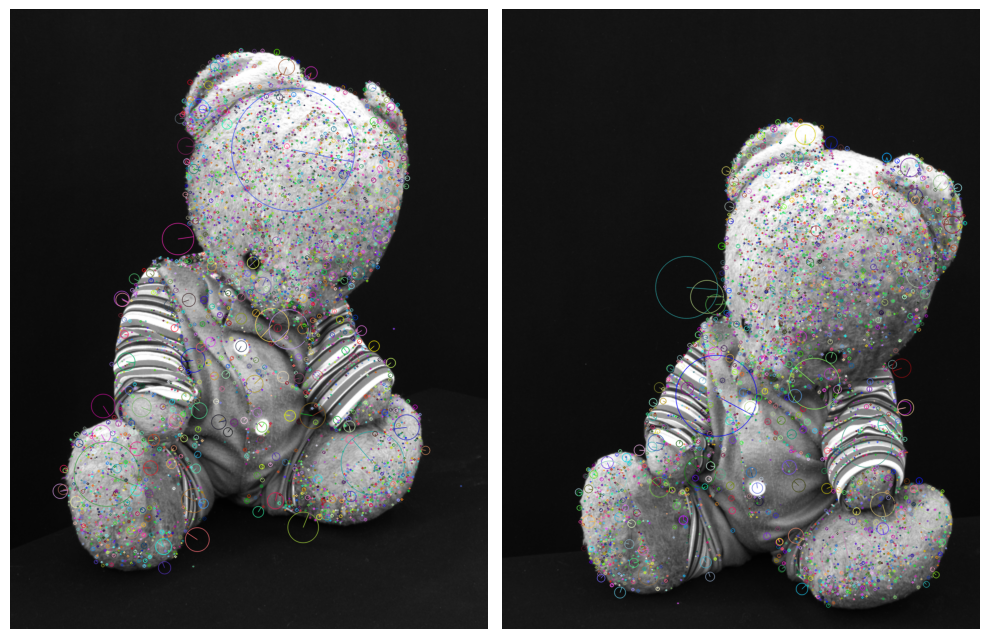

In [8]:
# Init SIFT extractor
sift = cv.SIFT_create()

# Extract the features, save them for later, and visualize
data['kpts'] = []
data['descr'] = []

fig, axes = plt.subplots(1, 2, figsize=(10, 8))
for gray, ax in zip(data['gray'], axes):
    kpts, descr = sift.detectAndCompute(gray, None)
    img_kpts = cv.drawKeypoints(gray, kpts, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    data['kpts'].append(kpts)
    data['descr'].append(descr)
    ax.imshow(img_kpts)
    ax.set_axis_off()
plt.tight_layout()

## Straightforward matching

Now, for each keypoint in the left image let's find the matching keypoint in the right image, i.e the closest keypoint in the descriptor space.

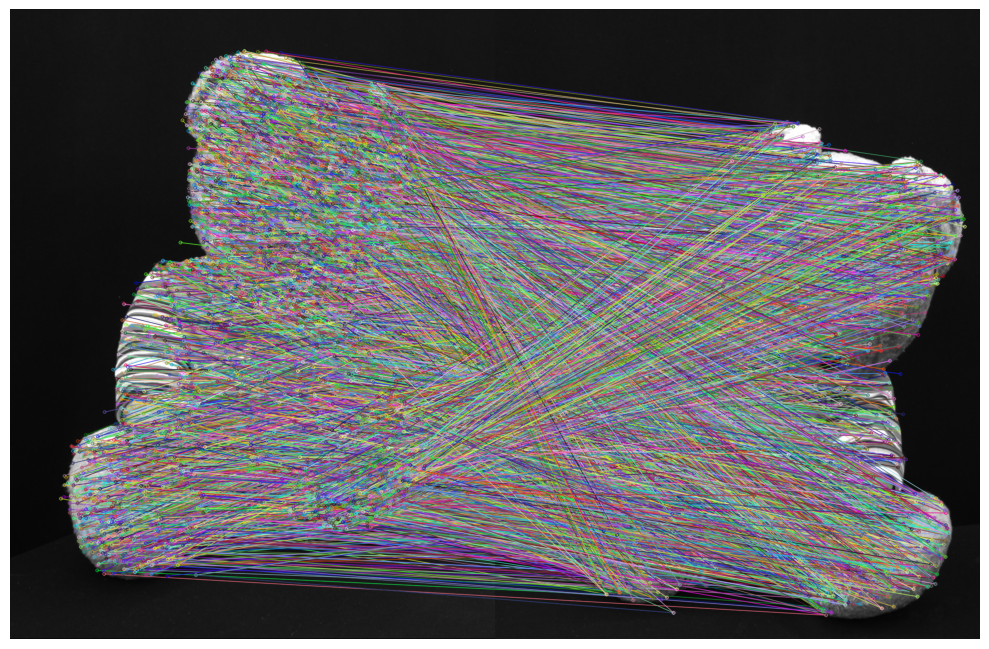

In [9]:
# Initialize the FLANN matcher and match the points in the left image to the points in the right image.
#
# Look for DescriptorMatcher_create() and match() at
#   https://docs.opencv.org/4.11.0/db/d39/classcv_1_1DescriptorMatcher.html
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
matches = matcher.match(data['descr'][0], data['descr'][1])

# Draw the matches using the utility function from utils.py
draw_matches(data['gray'], data['kpts'], matches)

Each line segment represents a "match", i.e a pair of points, one from the left image and the other one from the right image.
There are a lot of obviously false matches, for example the matches between the ears and the legs.
Let's try filtering them out.

## Lowe's ratio test

Let's filter the matches using Lowe's ratio test.
For each point in the left image, we find the two closest points in the right image (in the descriptor space) and only keep the match (the left point and the closest right point) if the distance to the closest point $d_0$ and the distance to the second closest point $d_1$ satisfy $d_0 \le d_1 \cdot r$, where $r$ is the maximum allowed ratio, which we chose as a parameter.

filter_ratio: Kept 1.4% of matches


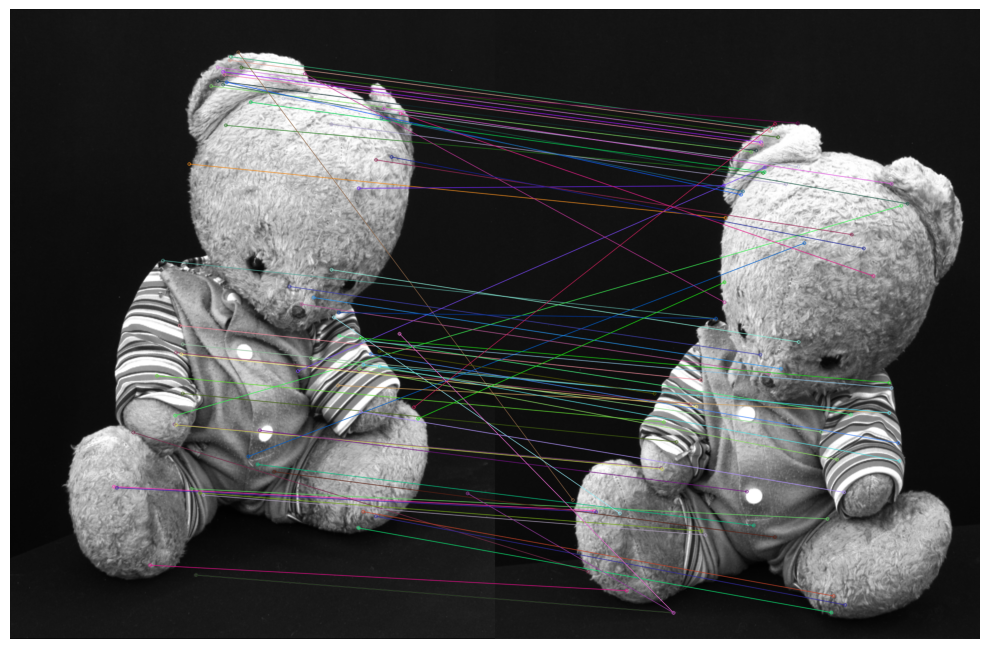

In [10]:
# Implement filtration of the matches using Lowe's ratio test

def mnf_ratio(descr_l, descr_r, max_ratio=0.7):
    r"""Finds matches for a pair of images and filters them out using Lowe's ratio test.

    Parameters
    ----------
    descr_l : np.ndarray
        of shape [descr_l_n, descr_d], descriptors of keypoints in the left image.
    descr_r : np.ndarray
        of shape [descr_r_n, descr_d], descriptors of keypoints in the right image.
   
    Parameters of filter_ratio
    --------------------------
    max_ratio

    Returns
    -------
    matches : list of cv.DMatch
        The matches that pass the test.
    """
    # For each descr_l find the two nearest descr_r, then apply the ratio test.
    #
    # Look for knnMatch() at
    #   https://docs.opencv.org/4.11.0/db/d39/classcv_1_1DescriptorMatcher.html
    matches = matcher.knnMatch(descr_l, descr_r, k=2)
    matches = filter_ratio(matches, max_ratio)
    return matches


def filter_ratio(two_nn, max_ratio=1, verbose=True):
    r"""Filters out the matches using Lowe's ratio test.

    Parameters
    ----------
    two_nn : list of lists of cv.DMatch
        The list of matches, where each sublist is the [best, second_best] matches per keypoint.
    max_ratio : float
        Matches with d0 > d1 * max_ratio, where d0 and d1 are the distances to the best and second best matching points, are filtered out.

    Returns
    -------
    filtered_matches : list of cv.DMatch
        The list of best matches per keypoint that pass the test.
    """
    filtered_matches = []
    for match_pair in two_nn:
        # 只有当找到两个最近邻时才进行比率测试
        if len(match_pair) == 2:
            best_match, second_best_match = match_pair
            # Lowe's ratio test: 最佳匹配距离 / 次佳匹配距离 < max_ratio
            if best_match.distance < second_best_match.distance * max_ratio:
                filtered_matches.append(best_match)
        # 如果只有一个匹配，也可以保留（可选）
        elif len(match_pair) == 1:
            filtered_matches.append(match_pair[0])
    if verbose:
        kept_matches_perc = round(len(filtered_matches) / len(two_nn) * 100, 1)
        print(f'filter_ratio: Kept {kept_matches_perc}% of matches')
    return filtered_matches


matches = mnf_ratio(data['descr'][0], data['descr'][1])
draw_matches(data['gray'], data['kpts'], matches)

Try different values of the maximum allowed ratio $r$.
**How does the number of matches change depending on this value?**

## Left-right check

Let's check how the left-to-right matches differ from the right-to-left ones.

In [11]:
max_ratio = .8

# Find left-to-right matches, i.e pairs of points (Pl, Pr) in which the point from the right image Pr is the closest point in the right image to the point from the left image Pl. 
matches = mnf_ratio(data['descr'][0], data['descr'][1], max_ratio)

# Find right-to-left matches, i.e pairs of points (Pr, Pl) in which the point from the left image Pl is the closest point in the left image to the point from the right image Pr.
matches_rtol = mnf_ratio(data['descr'][1], data['descr'][0], max_ratio)

# Draw left-to-right and right-to-left matches and switch between them to see the difference
match_color = None
# match_color = (255, 255, 0)  # uncomment to use the same color for match-lines in both figures to better see that they are different
fig_ltor = draw_matches(data['gray'], data['kpts'], matches, match_color=match_color)
fig_rtol = draw_matches_rtol(data['gray'], data['kpts'], matches_rtol, match_color=match_color)
show_fig_switcher(fig_ltor, fig_rtol)

filter_ratio: Kept 5.4% of matches
filter_ratio: Kept 4.8% of matches


Button(description='Switch figure', style=ButtonStyle())

Output()

Notice that there are pairs of points $(P_l, P_r)$ in the left-to-right matches such that the point $P_l$ is not the nearest neighbor of $P_r$ in the right-to-left matches.

Let's only keep the pairs of points in which both points are the nearest neighbors of each other, i.e the matches consistent with both the left-to-right and right-to-left matching.

In [12]:
# Implement filtration of the matches using left-right consistency check

def mnf_ratio_lr(descr_l, descr_r, max_ratio=.8):
    r"""Finds matches for a pair of images and filters them out using Lowe's ratio test and then the left-right consistency check.

    Parameters
    ----------
    descr_l : np.ndarray
        of shape [descr_l_n, descr_d], descriptors of keypoints in the left image.
    descr_r : np.ndarray
        of shape [descr_r_n, descr_d], descriptors of keypoints in the right image.
   
    Parameters of mnf_ratio
    -----------------------
    max_ratio

    Returns
    -------
    matches : list of cv.DMatch
        The left-right matches that pass the tests.
    """
    matches_ltor = mnf_ratio(descr_l, descr_r, max_ratio)
    matches_rtol = mnf_ratio(descr_r, descr_l, max_ratio)
    matches = filter_lr_consist(matches_ltor, matches_rtol)
    return matches


def filter_lr_consist(matches_ltor, matches_rtol, verbose=True):
    r"""Filters out the matches using left-right consistency check.

    Parameters
    ----------
    matches_ltor : list of cv.DMatch
        The left-right matches.
    matches_rtol : list of cv.DMatch
        The right-left matches.

    Returns
    -------
    filtered_matches_ltor : list of cv.DMatch
        The left-right matches that pass the left-right consistency check.
    """
    filtered_matches_ltor = []
    
    # 创建右到左匹配的字典，用于快速查找
    # 键是右图的关键点索引，值是左图的关键点索引
    rtol_dict = {}
    for match in matches_rtol:
        # 在右到左匹配中，queryIdx是右图的关键点，trainIdx是左图的关键点
        rtol_dict[match.queryIdx] = match.trainIdx
    
    # 检查每个左到右匹配的一致性
    for match_ltor in matches_ltor:
        # 在左到右匹配中，queryIdx是左图的关键点，trainIdx是右图的关键点
        left_idx = match_ltor.queryIdx
        right_idx = match_ltor.trainIdx
        
        # 检查一致性：如果右图的点right_idx在右到左匹配中对应的左图点是left_idx，
        # 那么这个匹配是一致的
        if right_idx in rtol_dict and rtol_dict[right_idx] == left_idx:
            filtered_matches_ltor.append(match_ltor)
    
    if verbose:
        kept_matches_perc = round(len(filtered_matches_ltor) / len(matches_ltor) * 100, 1)
        print(f'filter_lr_consist: Kept {kept_matches_perc}% of matches')
    return filtered_matches_ltor


max_ratio = .8
matches = mnf_ratio_lr(data['descr'][0], data['descr'][1], max_ratio)
# Below, we find the right-to-left matches merely for visualization,
# otherwise it is unnecessary, since ltor and rtol matches are the same after the left-right check (with a catch related to the matcher that we use)
matches_rtol = mnf_ratio_lr(data['descr'][1], data['descr'][0], max_ratio)

# Draw left-to-right and right-to-left matches and switch between them to see the difference
match_color = None
# match_color = (255, 255, 0)  # uncomment to use the same color for match-lines in both figures to better see that they are the same
fig_ltor = draw_matches(data['gray'], data['kpts'], matches, match_color=match_color)
fig_rtol = draw_matches_rtol(data['gray'], data['kpts'], matches_rtol, match_color=match_color)
show_fig_switcher(fig_ltor, fig_rtol)

filter_ratio: Kept 5.5% of matches
filter_ratio: Kept 4.7% of matches
filter_lr_consist: Kept 31.3% of matches
filter_ratio: Kept 4.6% of matches
filter_ratio: Kept 5.7% of matches
filter_lr_consist: Kept 40.4% of matches


Button(description='Switch figure', style=ButtonStyle())

Output()

**Why do the left-to-right matches differ from the right-to-left ones even after both sets were filtered using the left-right consistency check?**
Hint: recall the drawbacks of the initial matching method that we use (without any filtration).

## Geometric consistency

We can further expect the whole set of good matches to be consistent with some geometric transformation between the left and right image spaces.
Each pair of the matched points defines a similarity transformation between their respective neighborhoods, i.e a composition of translation, rotation, and scaling.
Let's try finding the largest group of matches consistent with some similarity transformation between the image spaces.

Let's do this using the following RANSAC-based algorithm:
1. Take a random match and find its respective transformation between the image spaces.
2. Map all the left keypoints to the right image space using this transformation.
3. Check if the mapped positions are within a distance threshold to the matched right keypoints.
   The matches that pass the check are inliers.
4. Save the largest set of inliers and repeat until we are satisfied with the solution or until we run out of computational budget (e.g number of iterations).

filter_ratio: Kept 5.2% of matches
filter_ratio: Kept 4.6% of matches
filter_lr_consist: Kept 33.9% of matches


  0%|          | 0/10 [00:00<?, ?it/s]

filter_geom_consistency: Kept 100.0% of matches


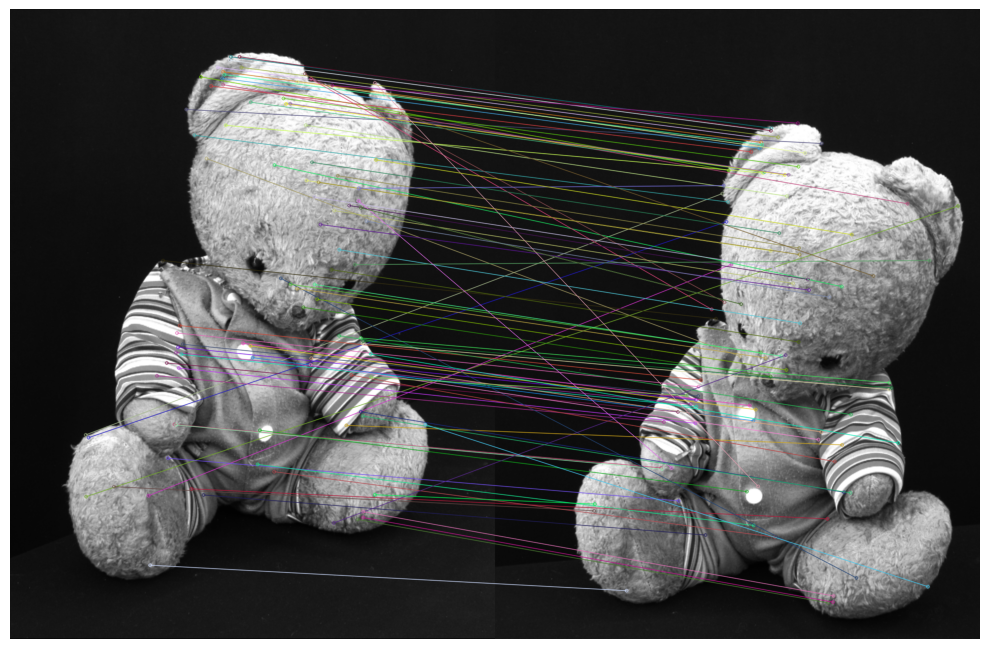

In [16]:
# Implement filtration of the matches using geometric consistency check

from tqdm.auto import tqdm  # let's use tqdm for monitoring the progress of RANSAC iterations


def filter_geom_consistency(matches, kpts_l, kpts_r, max_inlier_dist_px=1000, iters_n=10, verbose=True):
    r"""Filters out the matches using geometric consistency check with a RANSAC-based algorithm.

    Parameters
    ----------
    matches : list of cv.DMatch
        The left-right matches.
    kpts_l : lists of cv.KeyPoint
    kpts_r : lists of cv.KeyPoint
        All keypoints detected on the left and rigt images.
    max_inlier_dist_px : float
        Max distance between the position of the left keypoint mapped to the right image and the respective right matching keypoint for inlier.
    iters_n : int
        Maximum number of RANSAC iterations.
    verbose : bool
        If True, prints the progression of scores and best scores.

    Returns
    -------
    filtered_matches : list of cv.DMatch
        The largest found group of matches consistent with some similarity transformation.
    """ 
    best_inliers_n, best_inliers = 0, None
    # 提取匹配点的坐标
    pts_l = np.array([kpts_l[m.queryIdx].pt for m in matches], dtype=np.float32)
    pts_r = np.array([kpts_r[m.trainIdx].pt for m in matches], dtype=np.float32)
    
    for iter_i in tqdm(range(iters_n)):  # tqdm produces a nice progressbar
        # Sample a pair of matched points and get the respective transform
        # Transform the left points to the right space using the sampled transform
        # Identify the inlier matches, for which the transformed left point is not farther from the respective right point than the threshold
        
        # 随机选择两个匹配点对来估计相似变换
        sample_indices = np.random.choice(len(matches), 2, replace=False)
        
        # 获取采样的点对
        sample_pts_l = pts_l[sample_indices]
        sample_pts_r = pts_r[sample_indices]
        
        # 计算相似变换矩阵 (2x3)
        # 使用OpenCV的estimateAffinePartial2D来计算相似变换
        # 或者手动计算相似变换参数
        try:
            # 使用最小二乘法估计相似变换
            transform_matrix = cv.estimateAffinePartial2D(
                sample_pts_l.reshape(-1, 1, 2), 
                sample_pts_r.reshape(-1, 1, 2)
            )[0]
            
            if transform_matrix is None:
                continue
            
        except:
            continue
        
        # Transform the left points to the right space using the sampled transform
        # 将所有左图点变换到右图空间
        ones = np.ones((len(pts_l), 1), dtype=np.float32)
        pts_l_homogeneous = np.hstack([pts_l, ones])  # 转换为齐次坐标
        pts_l_transformed = pts_l_homogeneous @ transform_matrix.T
        
        # Identify the inlier matches
        # 计算变换后的左图点与对应右图点之间的距离
        distances = np.linalg.norm(pts_l_transformed - pts_r, axis=1)
        
        # 找到距离小于阈值的内点
        inlier_mask = distances < max_inlier_dist_px
        inliers = [matches[i] for i in range(len(matches)) if inlier_mask[i]]
        
        
        # Update the solution
        inliers_n = len(inliers)
        if inliers_n > best_inliers_n:
            best_inliers_n, best_inliers = inliers_n, inliers
        if verbose:
            print(str(iter_i).rjust(6) + ': Number of inliers current ' + str(inliers_n).rjust(6) + '\t best ' + str(best_inliers_n).rjust(6))
     # 处理best_inliers为None的情况
    if best_inliers is None:
        best_inliers = []
        print("Warning: No valid transformation found, returning empty list")
    kept_matches_perc = round(len(best_inliers) / len(matches) * 100, 1)
    print(f'filter_geom_consistency: Kept {kept_matches_perc}% of matches')
    return best_inliers


# Reinit FLANN matcher after we used bruteforce before
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)

matches = mnf_ratio_lr(data['descr'][0], data['descr'][1], max_ratio=.8)
matches = filter_geom_consistency(matches, data['kpts'][0], data['kpts'][1], max_inlier_dist_px=1000, iters_n=10, verbose=False)
draw_matches(data['gray'], data['kpts'], matches)

## Geometric consistency and perspective distortion

Let's try using our geometric consistency check with a simple planar object but for a pair of images with a significant change of the viewpoint.

First, let's look at the matches without the geometic consistency check.

filter_ratio: Kept 5.7% of matches
filter_ratio: Kept 4.7% of matches
filter_lr_consist: Kept 25.0% of matches


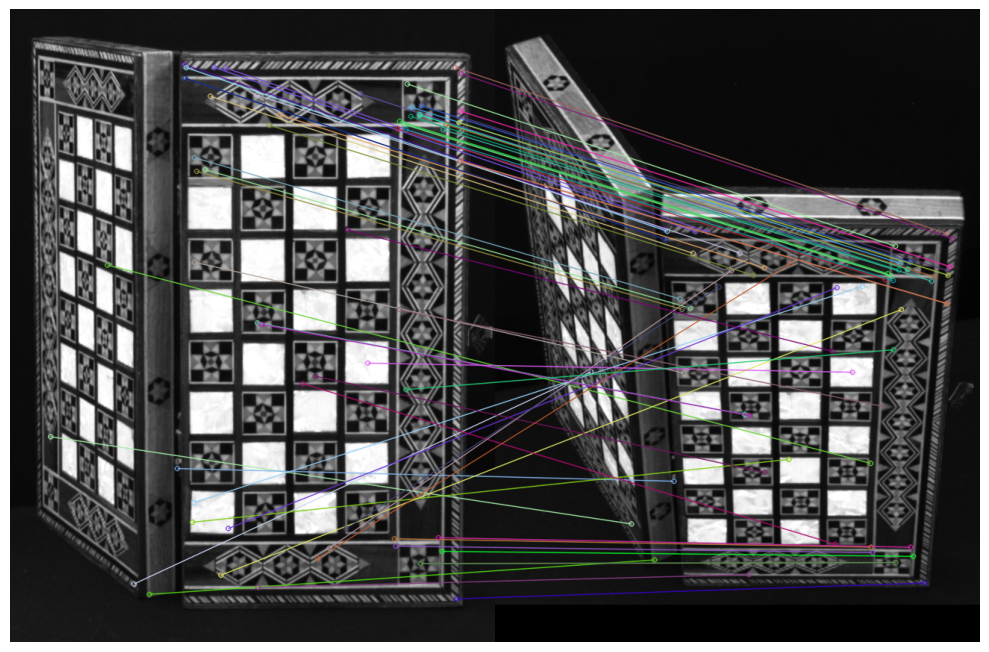

In [17]:
# Load the data
data['img'] = load_chessboard(data_dir)
data['gray'] = [np.clip(img.mean(-1).round(), 0, 255).astype(np.uint8) for img in data['img']]

# Reinit feature extractor and matcher
sift = cv.SIFT_create()
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)

# Extract features
data['kpts'] = []
data['descr'] = []
for gray in data['gray']:
    kpts, descr = sift.detectAndCompute(gray, None)
    img_kpts = cv.drawKeypoints(gray, kpts, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    data['kpts'].append(kpts)
    data['descr'].append(descr)

# Get the matches with the ratio and the left-right checks
matches = mnf_ratio_lr(data['descr'][0], data['descr'][1], max_ratio=.7)
draw_matches(data['gray'], data['kpts'], matches)

Now let's look at the matches after geometric verification.

filter_ratio: Kept 5.8% of matches
filter_ratio: Kept 4.6% of matches
filter_lr_consist: Kept 23.5% of matches


  0%|          | 0/10000 [00:00<?, ?it/s]

filter_geom_consistency: Kept 43.3% of matches


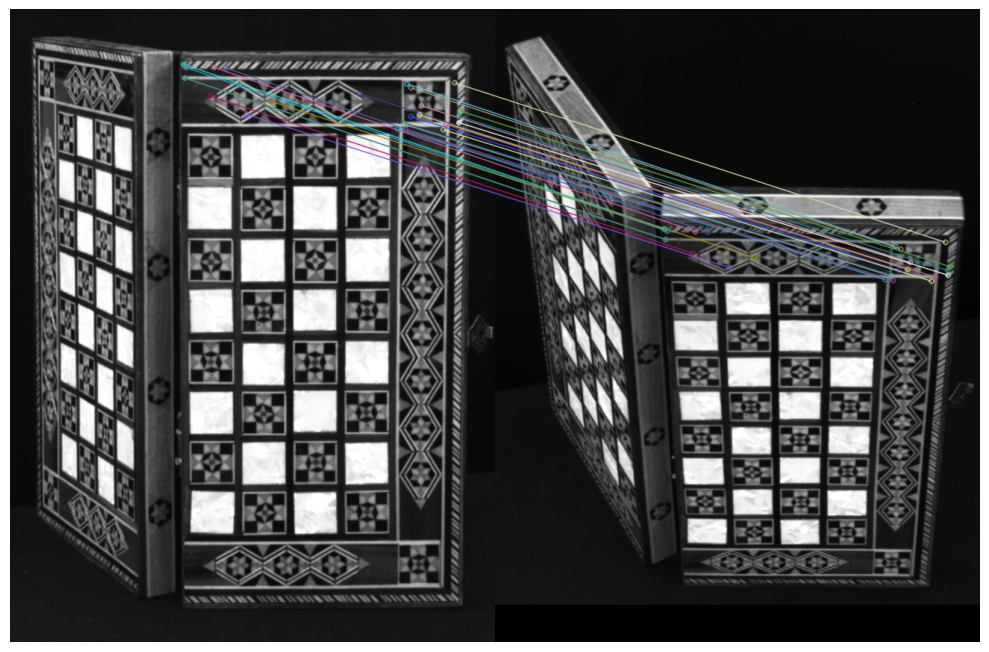

In [18]:
matches = mnf_ratio_lr(data['descr'][0], data['descr'][1], max_ratio=.7)
matches = filter_geom_consistency(matches, data['kpts'][0], data['kpts'][1], max_inlier_dist_px=10, iters_n=10_000, verbose=False)
draw_matches(data['gray'], data['kpts'], matches)

We loose a significant portion of obviously good matches in one or more corners.
**Why?**